 <center>



 <h1>Final Assessment - Advanced Natural Language Processing</h1>



 <i>



 Course: 22DM015 Advanced Methods in Natural Language Processing <br>



 Author(s): Ferran Boada Bergadà, Julián Romero, Lucia Sauer, Moritz Peist<br>



 Programme: DSDM



 <hr>



 ....



 </i>



 </center>



 <hr>

 ## Part 4

In [2]:
# Needed Imports
!pip install python-dotenv
!pip install -U datasets fsspec


import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from dotenv import load_dotenv
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    get_scheduler,
    EarlyStoppingCallback
)

import random
from datasets import load_dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [3]:
# Global constants
DATA_PATH = "../data/"
RESULTS_PATH = "./results/"
MODELS_PATH = "./models/"
SPLITS = {
    "train": "patent/train-00000-of-00001.parquet",
    "validation": "patent/validation-00000-of-00001.parquet",
    "test": "patent/test-00000-of-00001.parquet",
}
#SPLITS = {
#    "train": "patents_train.parquet",
#    "validation": "patents_validation.parquet",
#    "test": "patents_test.parquet",
#}

# Create directories for persistence
os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

LABELS = {
    0: "Human Necessities",
    1: "Performing Operations; Transporting",
    2: "Chemistry; Metallurgy",
    3: "Textiles; Paper",
    4: "Fixed Constructions",
    5: "Mechanical Engineering; Lighting; Heating; Weapons; Blasting",
    6: "Physics",
    7: "Electricity",
    8: "General tagging of new or cross-sectional technology",
}

# drive dir
OUTPUT_DIR = "/content/drive/MyDrive/NLP_models"

# part 3
model_ckpt   = "FacebookAI/roberta-base"
drive_model_path = f"{OUTPUT_DIR}/{model_ckpt}"



In [4]:
##### Load the best model to /content/models/best_model ########

# mount drive

from google.colab import drive
drive.mount('/content/drive')

# load model

model_colab_path = os.path.join(MODELS_PATH, "best_model")

model_drive_path = drive_model_path

os.makedirs(model_colab_path, exist_ok=True)

!cp -r "$model_drive_path"/* "$model_colab_path"

print("Loaded content")
!ls "$model_colab_path"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded content
config.json	   results_100		    tokenizer.json
merges.txt	   special_tokens_map.json  training_args.bin
model.safetensors  tokenizer_config.json    vocab.json


In [5]:
# # Part 4: Model Distillation and Quantization

# ## Setup
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging
# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load the model initially
model = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# check model
model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [6]:
# Custom compute_metrics function from baseline
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", zero_division=0
    )
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


os.makedirs(DATA_PATH, exist_ok=True)

# updated load_split

def load_split(split_name, cache_filename, data_path="../data", dataset="ccdv/patent-classification", config="abstract"):
    local_path = os.path.join(data_path, cache_filename)

    # If already cached locally, load from file
    if os.path.exists(local_path):
        print(f"Loading cached split from {local_path}")
        return pd.read_parquet(local_path)

    print(f"Loading from Hugging Face: {dataset} ({config}) [{split_name}]")
    os.makedirs(os.path.dirname(local_path), exist_ok=True)

    # Load split from HF datasets
    dataset_split = load_dataset(dataset, config, split=split_name)

    # Convert to DataFrame and cache
    df = dataset_split.to_pandas()
    df.to_parquet(local_path, index=False)

    return df

class PatentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)



### Section a) part 1: Direct Quantization
Before the full distillation of the best model, we inspect the effects of quantizing it directly. We test both models on a small subsample for efficiency.

In [13]:

# ##  a1. Direct Quantization (tested on subsample)

test_sample = 500

# Load and tokenize test set
df_test = load_split("test", SPLITS["test"], data_path=DATA_PATH).sample(n=test_sample, random_state=SEED)
test_encodings = tokenizer(
    df_test["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
test_dataset = PatentDataset(test_encodings, df_test["label"].tolist())


def get_model_size(model):
    tmp_path = "./temp_model.pt"
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / 1e6
    os.remove(tmp_path)
    return size_mb

def print_size_of_model(model, name):
    size_mb = get_model_size(model)
    print(f"{name} Size (MB): {size_mb:.2f}")


def evaluate_model(model, label="", device="cuda"): # Added device argument, default is cuda
    # Create TrainingArguments specific for evaluation
    # This allows setting the device without affecting training args
    eval_args = TrainingArguments(
        output_dir=f"./eval_results_{label}",
        per_device_eval_batch_size=8, # Use a reasonable batch size
        dataloader_num_workers=2,     # Add workers for potentially faster data loading on CPU
        report_to=[],                 # Disable logging
        no_cuda=True if device == "cpu" else False, # Disable CUDA if device is CPU
        seed=SEED,                    # Ensure reproducibility
    )

    # Pass the model's device to the trainer implicitly via no_cuda in args
    # The Trainer will automatically move the model to the device specified by args.no_cuda
    trainer = Trainer(model=model, args=eval_args, compute_metrics=compute_metrics)

    start = time.time()
    # No need to pass eval_dataset directly if it's part of trainer init,
    # but the evaluate method takes it as an argument.
    metrics = trainer.evaluate(eval_dataset=test_dataset)
    end = time.time()
    print(f"{label} - Eval time: {end - start:.2f}s")
    print(metrics)
    return metrics

# Quantize the model before evaluating it.

# Ensure the original model is on CPU before quantization.
model_for_quantization = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
model_for_quantization.cpu() # Ensure the model is on CPU for dynamic quantization

only_quantized_model = torch.quantization.quantize_dynamic(
    model_for_quantization, # Quantize the CPU version of the model
    {torch.nn.Linear},
    dtype=torch.qint8
)


print("Original Model Size:")
# Evaluate size of the original model
size_original = get_model_size(model)
print_size_of_model(model, "original")

print("Quantized Model Size:")
# Evaluate size of the quantized model (should be on CPU)
size_quantized = get_model_size(only_quantized_model)
print_size_of_model(only_quantized_model, "quantized")


print("Original Model Evaluation (run on CPU for fair comparison):")
original_model_for_eval = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
original_model_for_eval.cpu()  # Ensure it's on CPU
original_metrics = evaluate_model(original_model_for_eval, "Original", device="cpu")

print("Quantized Model Evaluation (run on CPU):")
# Pass device="cpu" when evaluating the quantized model
quantized_metrics = evaluate_model(only_quantized_model, "Quantized", device="cpu")

# save model
#torch.save(only_quantized_model.state_dict(), "./models/only_quantized_model.pt")
#print("model saved")



Loading cached split from ../data/patent/test-00000-of-00001.parquet
Original Model Size:
original Size (MB): 498.69
Quantized Model Size:
quantized Size (MB): 242.16
Original Model Evaluation (run on CPU for fair comparison):


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1577: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Original - Eval time: 47.35s
{'eval_loss': 0.8936390280723572, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.694, 'eval_f1': 0.6744400996893775, 'eval_precision': 0.6663692829793934, 'eval_recall': 0.694, 'eval_runtime': 47.3278, 'eval_samples_per_second': 10.565, 'eval_steps_per_second': 1.331}
Quantized Model Evaluation (run on CPU):


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1577: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Quantized - Eval time: 24.50s
{'eval_loss': 0.9216004610061646, 'eval_model_preparation_time': 0.0024, 'eval_accuracy': 0.672, 'eval_f1': 0.6532460625287408, 'eval_precision': 0.6444894398180959, 'eval_recall': 0.672, 'eval_runtime': 24.4991, 'eval_samples_per_second': 20.409, 'eval_steps_per_second': 2.572}


In [14]:
def compute_percent_change(original, quantized, is_higher_better=True):
    if original == 0:
        return "N/A"
    change = ((quantized - original) / original) * 100
    direction = change if is_higher_better else -change
    sign = "+" if direction >= 0 else "-"
    return f"{sign}{abs(direction):.1f}%"

comparison_data = {
    "Model": ["Original", "Quantized", "Δ (%)"],
    "Size (MB)": [
        f"{size_original:.1f}",
        f"{size_quantized:.1f}",
        compute_percent_change(size_original, size_quantized, is_higher_better=False),
    ],
    "Accuracy": [
        f"{original_metrics['eval_accuracy']:.4f}",
        f"{quantized_metrics['eval_accuracy']:.4f}",
        compute_percent_change(original_metrics['eval_accuracy'], quantized_metrics['eval_accuracy']),
    ],
    "F1 Score": [
        f"{original_metrics['eval_f1']:.4f}",
        f"{quantized_metrics['eval_f1']:.4f}",
        compute_percent_change(original_metrics['eval_f1'], quantized_metrics['eval_f1']),
    ],
    "Precision": [
        f"{original_metrics['eval_precision']:.4f}",
        f"{quantized_metrics['eval_precision']:.4f}",
        compute_percent_change(original_metrics['eval_precision'], quantized_metrics['eval_precision']),
    ],
    "Recall": [
        f"{original_metrics['eval_recall']:.4f}",
        f"{quantized_metrics['eval_recall']:.4f}",
        compute_percent_change(original_metrics['eval_recall'], quantized_metrics['eval_recall']),
    ],
    "Eval Time (s)": [
        f"{original_metrics.get('eval_runtime', 0):.2f}",
        f"{quantized_metrics.get('eval_runtime', 0):.2f}",
        compute_percent_change(original_metrics.get('eval_runtime', 0), quantized_metrics.get('eval_runtime', 0), is_higher_better=False),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
print(f"\n📊 Model Comparison ({test_sample} test examples on CPU):")
display(comparison_df)


📊 Model Comparison (500 test examples on CPU):


,Model,Size (MB),Accuracy,F1 Score,Precision,Recall,Eval Time (s)
0,Original,498.7,0.6940,0.6744,0.6664,0.6940,47.33
1,Quantized,242.2,0.6720,0.6532,0.6445,0.6720,24.50
2,Δ (%),+51.4%,-3.2%,-3.1%,-3.3%,-3.2%,+48.2%


In [15]:
# try with FP16 (Half Precision) for GPU


# Evaluate Original Model on GPU

print("Original Model Evaluation (on GPU):")
original_model_for_eval_gpu = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
original_model_for_eval_gpu.cuda()
original_metrics_gpu = evaluate_model(original_model_for_eval_gpu, "Original-GPU", device="cuda")
size_original = get_model_size(original_model_for_eval_gpu)
print_size_of_model(original_model_for_eval_gpu, "Original (GPU)")


# Evaluate FP16 Model on GPU

print("FP16 Model Evaluation (on GPU):")
fp16_model = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
fp16_model.half().cuda()  # Convert to half precision and move to GPU
fp16_metrics = evaluate_model(fp16_model, "FP16", device="cuda")
size_fp16 = get_model_size(fp16_model)
print_size_of_model(fp16_model, "FP16 (GPU)")


# Comparison Table

comparison_data = {
    "Model": ["Original (GPU)", "FP16 (GPU)", "Δ (%) vs Original"],
    "Size (MB)": [
        f"{size_original:.1f}",
        f"{size_fp16:.1f}",
        compute_percent_change(size_original, size_fp16, is_higher_better=False),
    ],
    "Accuracy": [
        f"{original_metrics_gpu['eval_accuracy']:.4f}",
        f"{fp16_metrics['eval_accuracy']:.4f}",
        compute_percent_change(original_metrics_gpu['eval_accuracy'], fp16_metrics['eval_accuracy']),
    ],
    "F1 Score": [
        f"{original_metrics_gpu['eval_f1']:.4f}",
        f"{fp16_metrics['eval_f1']:.4f}",
        compute_percent_change(original_metrics_gpu['eval_f1'], fp16_metrics['eval_f1']),
    ],
    "Precision": [
        f"{original_metrics_gpu['eval_precision']:.4f}",
        f"{fp16_metrics['eval_precision']:.4f}",
        compute_percent_change(original_metrics_gpu['eval_precision'], fp16_metrics['eval_precision']),
    ],
    "Recall": [
        f"{original_metrics_gpu['eval_recall']:.4f}",
        f"{fp16_metrics['eval_recall']:.4f}",
        compute_percent_change(original_metrics_gpu['eval_recall'], fp16_metrics['eval_recall']),
    ],
    "Eval Time (s)": [
        f"{original_metrics_gpu.get('eval_runtime', 0):.2f}",
        f"{fp16_metrics.get('eval_runtime', 0):.2f}",
        compute_percent_change(
            original_metrics_gpu.get('eval_runtime', 0),
            fp16_metrics.get('eval_runtime', 0),
            is_higher_better=False
        ),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
print(f"\n📊 Model Comparison ({test_sample} test examples on GPU):")
display(comparison_df)



Original Model Evaluation (on GPU):


Original-GPU - Eval time: 3.86s
{'eval_loss': 0.8936390280723572, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.694, 'eval_f1': 0.6744400996893775, 'eval_precision': 0.6663692829793934, 'eval_recall': 0.694, 'eval_runtime': 3.8573, 'eval_samples_per_second': 129.626, 'eval_steps_per_second': 16.333}
Original (GPU) Size (MB): 498.69
FP16 Model Evaluation (on GPU):


FP16 - Eval time: 1.13s
{'eval_loss': 0.8935546875, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.694, 'eval_f1': 0.6744400996893775, 'eval_precision': 0.6663692829793934, 'eval_recall': 0.694, 'eval_runtime': 1.1233, 'eval_samples_per_second': 445.123, 'eval_steps_per_second': 56.086}
FP16 (GPU) Size (MB): 249.39

📊 Model Comparison (500 test examples on GPU):


,Model,Size (MB),Accuracy,F1 Score,Precision,Recall,Eval Time (s)
0,Original (GPU),498.7,0.6940,0.6744,0.6664,0.6940,3.86
1,FP16 (GPU),249.4,0.6940,0.6744,0.6664,0.6940,1.12
2,Δ (%) vs Original,+50.0%,+0.0%,+0.0%,+0.0%,+0.0%,+70.9%


The isolated dynamic quantization step reduces the model size by more than half and decreases inference time also by nearly 50%, while maintaining reasonable performance — with less than a 3% drop relative to the original model's scores.

On the other hand, when applying FP16 (half-precision) quantization, the model size is reduced by exactly 50% (as a consequence of halving to 16-bit floats), and inference time drops to just 30% of the original — a significant speedup on GPU. Importantly, performance metrics remain virtually unchanged, showing that FP16 quantization is an effective method for reducing memory and compute overhead without compromising accuracy.

Now, let's perform the same comparison after applying only distillation.

### Section a) part 2: Direct Distillation



In [18]:

# ##  a2. Distillation

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
max_length = 256
num_epochs = 5

# Load the full train and validation dataset
train_df = load_split("train", "patent/train-00000-of-00001.parquet", data_path=DATA_PATH)
val_df = load_split("validation", "patent/validation-00000-of-00001.parquet", data_path=DATA_PATH)

# Filter for valid labels and sample
#--
#valid_labels = range(len(LABELS))

#train_df = train_df[train_df['label'].isin(valid_labels)].sample(n=500, random_state=SEED).reset_index(drop=True)
#val_df = val_df[val_df['label'].isin(valid_labels)].sample(n=200, random_state=SEED).reset_index(drop=True)
#--
#train_df = train_df[train_df['label'].isin(valid_labels)].reset_index(drop=True)
#val_df = val_df[val_df['label'].isin(valid_labels)].reset_index(drop=True)

# Tokenization
student_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = student_tokenizer(train_df["text"].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
val_encodings = student_tokenizer(val_df["text"].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
test_student_encodings = student_tokenizer(df_test["text"].tolist(),padding=True,truncation=True,max_length=max_length,return_tensors="pt")

train_dataset = PatentDataset(train_encodings, train_df["label"].tolist())
val_dataset = PatentDataset(val_encodings, val_df["label"].tolist())
test_student_dataset = PatentDataset(test_student_encodings, df_test["label"].tolist())

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_student_dataloader = DataLoader(test_student_dataset, batch_size=batch_size)
# for teacher
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


# Models: best as teacher (Roberta) and distilbert-base-uncased as student
teacher_model = AutoModelForSequenceClassification.from_pretrained(model_colab_path).to(DEVICE)
teacher_model.eval()

student_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(LABELS)
).to(DEVICE)

# inspect the pretrained student model
student_model



Loading cached split from ../data/patent/train-00000-of-00001.parquet
Loading from Hugging Face: ccdv/patent-classification (abstract) [validation]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


DistilBERT and RoBERTa differ significantly in terms of architecture complexity, parameter count, and intended use. DistilBERT is a lightweight, distilled version of BERT, featuring only 6 transformer layers compared to RoBERTa’s 12 layers, effectively halving the depth of the model. Both models use a hidden size of 768 and an intermediate size of 3072, but DistilBERT omits some components found in RoBERTa. The vocabulary size also differs, with RoBERTa supporting 50,265 tokens versus DistilBERT’s 30,522, reflecting RoBERTa’s pretraining on a larger and more diverse corpus

In [19]:
# Distillation Trainer (overriding Trainer loss)



class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, alpha=0.5, temperature=4.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model.to(self.model.device)
        self.teacher.eval()
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Student forward
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits
        student_loss = student_outputs.loss

        # Teacher forward
        with torch.no_grad():
            teacher_logits = self.teacher(**inputs).logits

        # KL divergence loss
        loss_kl = nn.KLDivLoss(reduction="batchmean")(
            F.log_softmax(student_logits / self.temperature, dim=-1),
            F.softmax(teacher_logits / self.temperature, dim=-1)
        ) * (self.temperature ** 2)

        # Combined loss
        loss = self.alpha * student_loss + (1 - self.alpha) * loss_kl

        return (loss, student_outputs) if return_outputs else loss



# Train student

training_args = TrainingArguments(
    output_dir="./models/distilled_student",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
  #  evaluation_strategy="epoch",
    eval_strategy = "epoch",

    save_strategy="epoch",                # required for early stopping
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,                   # keep only best checkpoint

    report_to=[],
    seed=SEED,
    logging_dir="./logs",

)

distilled_trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=student_tokenizer,
    compute_metrics=compute_metrics,
    teacher_model=teacher_model,
    # alpha controlling the balance between the student loss and teacher-student KL loss
    alpha=0.5,
    # smooths the probability distributions of logits
    temperature=4.0,

    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]

)

distilled_trainer.train()

# Save
student_model.save_pretrained("./models/distilled_student")
student_tokenizer.save_pretrained("./models/distilled_student")

<ipython-input-19-2717372612>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.039000,0.970165,0.487400,0.431933,0.628987,0.487400
2,0.910700,0.938460,0.558000,0.527339,0.620625,0.558000
3,0.842300,0.933205,0.596000,0.574343,0.662331,0.596000
4,0.790000,0.942579,0.602400,0.585652,0.647305,0.602400
5,0.751800,0.957546,0.603400,0.587350,0.641193,0.603400


('./models/distilled_student/tokenizer_config.json',
 './models/distilled_student/special_tokens_map.json',
 './models/distilled_student/vocab.txt',
 './models/distilled_student/added_tokens.json',
 './models/distilled_student/tokenizer.json')

In [20]:
# updated evaluate

def evaluate(model, dataloader, name="Model", label_dict=None, return_details=False):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_labels = []
    start = time.time()

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

            # Remove token_type_ids if using DistilBERT
            if isinstance(model, torch.nn.Module) and "token_type_ids" in inputs:
                try:
                    if model.config.model_type == "distilbert":
                        inputs.pop("token_type_ids", None)
                except AttributeError:
                    pass

            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    duration = time.time() - start
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    results = {
        "name": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "inference_time": duration,
    }

    print(f"\n📊 {name} Evaluation:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Inference Time (s): {duration:.2f}")

    report, cm = None, None
    if return_details and label_dict:
        present_labels = sorted(set(all_labels) | set(all_preds))
        target_names = [label_dict[i][:20] for i in present_labels]

        report = classification_report(
            all_labels, all_preds, labels=present_labels,
            target_names=target_names, zero_division=0
        )
        cm = confusion_matrix(all_labels, all_preds, labels=present_labels)

    return results, report, cm

In [21]:
# Evaluate both models on same test set subsample
student_metrics,_,_ = evaluate(student_model, test_student_dataloader, name="Student (Distilled)")
teacher_metrics,_,_ = evaluate(teacher_model, test_dataloader, name="Teacher (Original)")


📊 Student (Distilled) Evaluation:
Accuracy : 0.6120
Precision: 0.6808
Recall   : 0.6120
F1 Score : 0.5989
Inference Time (s): 1.55

📊 Teacher (Original) Evaluation:
Accuracy : 0.6940
Precision: 0.6664
Recall   : 0.6940
F1 Score : 0.6744
Inference Time (s): 3.02


In [22]:

teacher_size = get_model_size(teacher_model)
student_size = get_model_size(student_model)

In [23]:
# Create original two rows
comparison_df = pd.DataFrame([
    {
        "Model": teacher_metrics["name"],
        "Size (MB)": teacher_size,
        **{k.capitalize(): v for k, v in teacher_metrics.items() if k != "name"}
    },
    {
        "Model": student_metrics["name"],
        "Size (MB)": student_size,
        **{k.capitalize(): v for k, v in student_metrics.items() if k != "name"}
    }
])

# Create the percent change row
teacher_row = comparison_df.iloc[0]
student_row = comparison_df.iloc[1]

percent_change_row = {
    "Model": "Δ (%)"
}

for col in comparison_df.columns:
    if col == "Model":
        continue
    is_higher_better = False if "Size" in col.lower() else True
    percent_change_row[col] = compute_percent_change(teacher_row[col], student_row[col], is_higher_better)

# Append the change row to the DataFrame
comparison_df = pd.concat([comparison_df, pd.DataFrame([percent_change_row])], ignore_index=True)

# Display the table
print(f"\n📋 Model Comparison ({test_sample} test examples on {DEVICE}):")
display(comparison_df)




📋 Model Comparison (500 test examples on cuda):


,Model,Size (MB),Accuracy,Precision,Recall,F1,Inference_time
0,Teacher (Original),498.693639,0.694,0.666369,0.694,0.67444,3.022222
1,Student (Distilled),267.883366,0.612,0.680792,0.612,0.598912,1.554143
2,Δ (%),-46.3%,-11.8%,+2.2%,-11.8%,-11.2%,-48.6%


After applying direct distillation with a DistilBERT student, the model size also decreases by almost 50% due to the previously exposed characteristics of DistilBert in contrast to RoBERTa. The inference time for the analysed sample also decreases by a half. Unlike the two previous quantization cases, the performance of the model here is worse by more than 10% in accuracy and F1 score, but surprisingly, precision increases by 2% with respect to the original; this improvement could be attributed to the knowledge distillation process, which acts as a form of regularization. During training, the student model learns not only from the ground-truth labels but also from the softened probability distributions (soft targets) produced by the teacher model, which encode richer information about class similarities and ambiguities. However, these results were produced with only a fraction of the test data (in the next section we'll see the ultimate test).

\\
From all the results obtained in this section, it seems reasonable to apply the two techniques (distillation+quantization) to the original model in order to gain approx x4 in terms of size and inference speed, while keeping decent classification performance (considering that quantization doesn't decrease the scores).

## a. Model Distillation & Quantization (process and tools used)

In this section, we optimized our best-performing RoBERTa-based model by applying both knowledge distillation and quantization techniques — separately and (in the next section) in combination.

### Knowledge Distillation:
- A smaller **DistilBERT** student model was trained using soft targets generated by a fine-tuned RoBERTa teacher.
- We implemented a custom `DistillationTrainer`:
  - It combines the student’s classification loss with a **KL divergence loss** between teacher and student logits.
  - This allows the student to mimic the teacher’s output distribution instead of learning from only hard labels.
- Key parameters used:
  - **`alpha = 0.5`**: balances supervised and teacher-guided learning. Alpha = 0.5 means that the student weights equally the loss with respect to the teacher (soft) logits and the loss with respect to the training data.
  
    $$
    L_{\text{total}} = \alpha \cdot L_{\text{CE}}(y_{\text{student}}, y_{\text{true}}) + (1 - \alpha) \cdot L_{\text{KL}}\left(p_{\text{student}}^{(T)} \,\|\, p_{\text{teacher}}^{(T)}\right)
    $$

    Where:
    - $L_{\text{CE}}$: Cross-entropy loss between student predictions and ground-truth.
    - $L_{\text{KL}}$: Kullback-Leibler divergence between the softmax outputs of student and teacher.
    - $p^{(T)}$: Softmax distribution computed with temperature \( T \).

  - **`temperature = 4.0`**: softens the teacher’s outputs to provide richer gradient signals. The softened logits are passed through a temperature-scaled softmax function:

  $$
  p_i = \frac{\exp\left(\frac{z_i}{T}\right)}{\sum_j \exp\left(\frac{z_j}{T}\right)}
  $$

    Where:
    - $z_i$: logit for class $i$
    - $T$: temperature (e.g., 4.0)
    - $p_i$: softened probability for class $i$

### Quantization:
We experimented with two quantization techniques, each suited for different deployment environments:


- We applied **post-training dynamic quantization** using:
  - How it works:
  - Converts Linear layers’ weights from 32-bit floats to 8-bit integers.
  - Activations are quantized dynamically at runtime (inference time).
  - Results in reduced memory usage and faster inference on CPU — without retraining.
```python
torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
```

  

- We also applied FP16 Quantization (GPU)
 by converting models to half precision (16-bit floats) using .half().cuda().

  - This is fully compatible with GPU inference and provides:

  - A ~50% reduction in model size

  - Significant speedups (in our first test, inference time dropped to ~30% of the original)

  - Maintained model performance, with no meaningful loss in accuracy or F1



\\

Therefore, after these steps we can compare the performance of four different models:  
the Original best model, the Quantized original, the Distilled original, and the ultimate Quantized **and** Distilled model.

\\
Finally,  we can compare the Quantized **and** Distilled model to the original in terms of speed and performance.

### Section b) Quantize the distilled model and compare to the original (on full test data)


In [24]:
# === Load full-precision models ===

original_model = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
original_model = original_model.cuda()  # Full precision original model on GPU

distilled_model = AutoModelForSequenceClassification.from_pretrained("./models/distilled_student")
distilled_model = distilled_model.cuda()  # Full precision distilled model on GPU

# === Apply FP16 quantization for GPU ===

# Quantized distilled (FP16)
quantized_model = AutoModelForSequenceClassification.from_pretrained("./models/distilled_student")
quantized_model = quantized_model.half().cuda()  # FP16 on GPU

# Quantized original (FP16)
only_quantized_model = AutoModelForSequenceClassification.from_pretrained(model_colab_path)
only_quantized_model = only_quantized_model.half().cuda()  # FP16 on GPU

print("Models loaded")


Models loaded


In [25]:


# Load the full test data
df_test = load_split("test", SPLITS["test"], data_path=DATA_PATH)
test_encodings = tokenizer(
    df_test["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)
test_dataset = PatentDataset(test_encodings, df_test["label"].tolist())


# test data loader for original
test_dataloader = DataLoader(test_dataset, batch_size=8)
# test data loader for distilled
distilbert_tokenizer = AutoTokenizer.from_pretrained("./models/distilled_student")

test_encodings_distilled = distilbert_tokenizer(
    df_test["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

test_dataset_distilled = PatentDataset(test_encodings_distilled, df_test["label"].tolist())
test_dataloader_distilled = DataLoader(test_dataset_distilled, batch_size=8)


results = []
original_results, original_report, original_cm= evaluate(original_model, test_dataloader, name="Original",label_dict=LABELS, return_details=True)
results.append(original_results)
#results.append(evaluate(original_model, test_dataloader, name="Original"))

only_quantized_results, only_quantized_report, only_quantized_cm= evaluate(only_quantized_model, test_dataloader, name="Quantized",label_dict=LABELS, return_details=True)
results.append(only_quantized_results)
#results.append(evaluate(only_quantized_model, test_dataloader, name="Only Quantized"))

distilled_results, distilled_report, distilled_cm= evaluate(distilled_model, test_dataloader_distilled, name="Distilled",label_dict=LABELS, return_details=True)
results.append(distilled_results)
#results.append(evaluate(distilled_model, test_dataloader_distilled, name="Distilled"))
quantized_results, quantized_report, quantized_cm= evaluate(quantized_model, test_dataloader_distilled, name="Quantized Distilled",label_dict=LABELS, return_details=True)
results.append(quantized_results)
#results.append(evaluate(quantized_model, test_dataloader_distilled, name="Quantized Distilled"))

# === Record sizes ===
results[0]["size_mb"] = get_model_size(original_model)
results[1]["size_mb"] = get_model_size(only_quantized_model)
results[2]["size_mb"] = get_model_size(distilled_model)
results[3]["size_mb"] = get_model_size(quantized_model)

# === Final comparison table ===
comparison_df = pd.DataFrame(results)[["name", "size_mb", "accuracy", "f1", "precision", "recall", "inference_time"]]
comparison_df = comparison_df.rename(columns={
    "name": "Model", "size_mb": "Size (MB)", "inference_time": "Eval Time (s)"
})
print("\n📋 Final Comparison Table:")
display(comparison_df.round(4))

Loading cached split from ../data/patent/test-00000-of-00001.parquet

📊 Original Evaluation:
Accuracy : 0.6666
Precision: 0.6327
Recall   : 0.6666
F1 Score : 0.6419
Inference Time (s): 64.14

📊 Quantized Evaluation:
Accuracy : 0.6666
Precision: 0.6327
Recall   : 0.6666
F1 Score : 0.6419
Inference Time (s): 14.21

📊 Distilled Evaluation:
Accuracy : 0.5906
Precision: 0.6422
Recall   : 0.5906
F1 Score : 0.5672
Inference Time (s): 34.76

📊 Quantized Distilled Evaluation:
Accuracy : 0.5906
Precision: 0.6422
Recall   : 0.5906
F1 Score : 0.5672
Inference Time (s): 7.66

📋 Final Comparison Table:


,Model,Size (MB),accuracy,f1,precision,recall,Eval Time (s)
0,Original,498.6936,0.6666,0.6419,0.6327,0.6666,64.1399
1,Quantized,249.3886,0.6666,0.6419,0.6327,0.6666,14.2068
2,Distilled,267.8834,0.5906,0.5672,0.6422,0.5906,34.7557
3,Quantized Distilled,133.9626,0.5906,0.5672,0.6422,0.5906,7.6621


In [26]:
# print the classification reports
print("\n📄 Original Classification Report:")
print(original_report)

print("\n📄 Quantized Distilled Classification Report:")
print(quantized_report)


📄 Original Classification Report:
                      precision    recall  f1-score   support

   Human Necessities       0.74      0.81      0.78       754
Performing Operation       0.59      0.63      0.61       649
Chemistry; Metallurg       0.66      0.69      0.68       394
     Textiles; Paper       0.58      0.59      0.58        44
 Fixed Constructions       0.65      0.65      0.65       156
Mechanical Engineeri       0.59      0.69      0.64       358
             Physics       0.68      0.78      0.73      1107
         Electricity       0.72      0.75      0.73      1035
General tagging of n       0.25      0.05      0.09       503

            accuracy                           0.67      5000
           macro avg       0.61      0.63      0.61      5000
        weighted avg       0.63      0.67      0.64      5000


📄 Quantized Distilled Classification Report:
                      precision    recall  f1-score   support

   Human Necessities       0.79      0.73      


📊 Original Confusion Matrix:


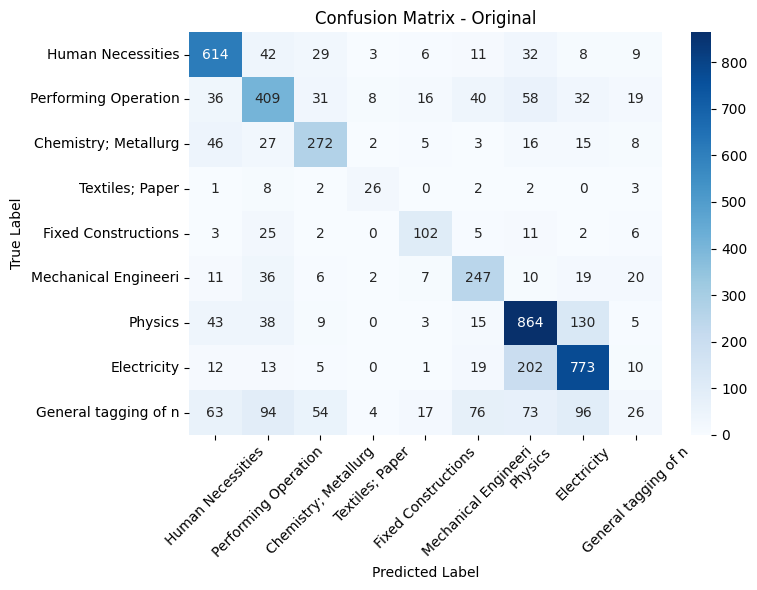


📊 Quantized Distilled Confusion Matrix:


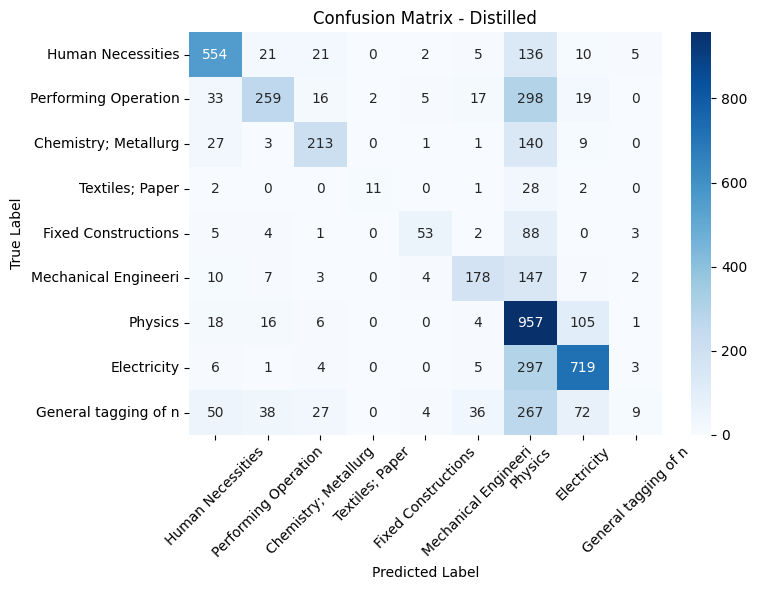

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original Model Confusion Matrix
print("\n📊 Original Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(
    original_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label[:20] for label in LABELS.values()],
    yticklabels=[label[:20] for label in LABELS.values()],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {results[0]['name']}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Quantized Distilled Model Confusion Matrix
print("\n📊 Quantized Distilled Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(
    quantized_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[label[:20] for label in LABELS.values()],
    yticklabels=[label[:20] for label in LABELS.values()],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {results[2]['name']}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## b. Performance and Speed Comparison

After evaluating the two models (original best and quantized distilled) on the full test data, we find new interesting insights that update our previous intuitions.

\\

### Observations:
- **Size**: As expected, the quantized distilled model is the smallest of all with almost one fourth of the original size (1/2 * 1/2).
- **Speed**: Unlike in previous smaller tests, the inference speed ratio skyrockets; the quantized distilled predicts with 1/9 of the original model computation time, which clearly shows that time scales non linearly with respect to data size at least for this particular setting (distilled and quantized on GPU). In fact, quantization seems to be the main responsible of that, since the inference-time-ratio between original-quantized and distilled-quantized+distilled is almost 1/5 in the two cases, while the ratio between original-distilled is similar to the previous (smaller) test.
- **Performance**: Like in the first test, we confirm some of the conclusions we already had before; there's a difference of roughly 7% in accuracy, recall and F1 in favor of the original best model, which shows that in general it classifies better because it captures more nuances in the language of the abstracts (thanks to the greater complexity of RoBERTa architecture).
However, interestingly we also confirm that precision for the distilled model is slightly higher (like 1%). If we take a look at the class-wise metrics and confusion matrices above, it's clear that the distilled model for some reason is more precise for all the categories except for physics, since what we observe is that it's biased towards this label and tends to classify many abstracts from other categories (especially for Performing Operations, Electricity and New technology) to physics, while being more conservative for the other labels.


## c. Analysis and Improvements

The student model, despite being distilled and quantized for efficiency, demonstrates a clear trade-off between performance and resource optimization.

### Deficiencies:
- Reduced Overall Performance: The distilled student model underperforms compared to the original RoBERTa-based teacher model, with an observed drop of ~7% in accuracy, F1-score, and recall. This suggests that the student model struggles to generalize as effectively, likely due to reduced representational capacity (fewer layers, less contextual depth).

- Label Bias: A notable bias is observed in the student’s predictions—particularly a tendency to overpredict the “Physics” category. This results in misclassifying examples from other classes (e.g., Operations & Transport, Electricity) into Physics. While this bias boosts precision in certain classes, it compromises recall and introduces confusion, especially for less-represented or more semantically complex labels.

### Potential Improvements:
- Class-Balanced Distillation Loss: To introduce class weights or focal loss during distillation to discourage overfitting to dominant classes (like Physics in this case) could improve performance on underrepresented categories.

- Intermediate Layer Supervision: That is, to incorporate intermediate feature matching (not just logits) between the teacher and student. This could help the student capture more structural language features learned by the teacher.

- Alternative Architectures: We could have also experimented with other efficient transformer variants like TinyBERT, ALBERT, or MobileBERT, which may strike a better balance between speed and performance. Or even customize the student model architecture to have more control on the learning (despite this would be more suitable for a particular research line, rather than a case like this, where we just wanted to deploy an efficient version of the original).

- Hyperparameter tuning during student training: Last but not least, it's still not clear how to perform the choice of temperature and alpha parameters (apart from the "classical" hyperparameters like learning rate, epochs, etc). Of course, this choice can also be conditioned on the use case (like an alpha more tilted towards learning from the teacher if we care more about replicating the pros and cons of the original model, rather than just optimizing performance in the distilled...).


